# Loading and Organizing Time Series Data from CSV


The following notebook demonstrates a systematic approach to loading and organizing time series data from a CSV file using a custom class structure. The goal is to handle multiple time series within a single CSV file, each associated with specific metadata. The dataset used in this example pertains to human activity recognition (HAR) with smartphones.

In [1]:
%load_ext autoreload
%autoreload 2
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import sys
sys.path.append('../../')
from tsbench.tslib.base.timeseries_dataset import TimeSeries, TimeSeriesDataset, TimeSeriesMeta

**Our data contains multiple timeseries within single csv file.
The goal is to have a class (instance) which will returne single time series by calling ```get_index()``` method**
<hr>

# Data

First step is to get access to our data.

In [2]:
TRAIN_FILE = '../../datafiles/stocknewseventssentiment-snes-10/data.csv'
TRAIN_FILE = Path(TRAIN_FILE)

In [3]:
train_df = pd.read_csv(TRAIN_FILE)
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Security,GICS Sector,...,News - Analyst Comments,News - Stocks,News - Dividends,News - Corporate Earnings,News - Mergers & Acquisitions,News - Store Openings,News - Product Recalls,News - Adverse Events,News - Personnel Changes,News - Stock Rumors
0,2020-09-30,160.929993,163.100006,158.610001,160.179993,150.921692,3056900.0,MMM,3M,Industrials,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-01,160.669998,161.899994,157.720001,158.789993,149.612045,1989100.0,MMM,3M,Industrials,...,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-10-02,156.470001,161.940002,156.250000,160.360001,151.091309,1768600.0,MMM,3M,Industrials,...,2.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2020-10-05,162.250000,163.500000,161.759995,162.750000,153.343170,1457000.0,MMM,3M,Industrials,...,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
4,2020-10-06,163.440002,165.699997,161.830002,162.229996,152.853195,2021900.0,MMM,3M,Industrials,...,3.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0


In [4]:
# this will be the development dataframe
dev_df = train_df[train_df.columns[1:27]].loc[train_df['Symbol']=='MMM']

In [5]:
# we will split this dataset by subject and activity and put them into a consecutive timeseries
# This is just to keep this code simple. In reality, you would want to do this in a more
# sophisticated way, keeping different timeseries apart from each other.
dev_df

,Open,High,Low,Close,Adj Close,Volume,Symbol,Security,GICS Sector,GICS Sub-Industry,...,News - Analyst Comments,News - Stocks,News - Dividends,News - Corporate Earnings,News - Mergers & Acquisitions,News - Store Openings,News - Product Recalls,News - Adverse Events,News - Personnel Changes,News - Stock Rumors
0,160.929993,163.100006,158.610001,160.179993,150.921692,3056900.0,MMM,3M,Industrials,Industrial Conglomerates,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,160.669998,161.899994,157.720001,158.789993,149.612045,1989100.0,MMM,3M,Industrials,Industrial Conglomerates,...,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,156.470001,161.940002,156.250000,160.360001,151.091309,1768600.0,MMM,3M,Industrials,Industrial Conglomerates,...,2.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,162.250000,163.500000,161.759995,162.750000,153.343170,1457000.0,MMM,3M,Industrials,Industrial Conglomerates,...,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
4,163.440002,165.699997,161.830002,162.229996,152.853195,2021900.0,MMM,3M,Industrials,Industrial Conglomerates,...,3.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,131.529999,134.550003,131.240005,134.330002,134.330002,3659300.0,MMM,3M,Industrials,Industrial Conglomerates,...,10.0,10.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0
437,134.410004,134.669998,132.289993,132.800003,132.800003,2388600.0,MMM,3M,Industrials,Industrial Conglomerates,...,5.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
438,133.860001,134.570007,130.149994,130.330002,130.330002,2408300.0,MMM,3M,Industrials,Industrial Conglomerates,...,7.0,7.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0
439,130.000000,130.339996,128.809998,129.770004,129.770004,2821100.0,MMM,3M,Industrials,Industrial Conglomerates,...,8.0,9.0,2.0,1.0,3.0,0.0,0.0,5.0,0.0,0.0



<hr>

# Structure of the code

Before analysing the implementation, we should discover the structure of the code: namely classes, their general purpose an relation to each other.


<hr>

## Datasets
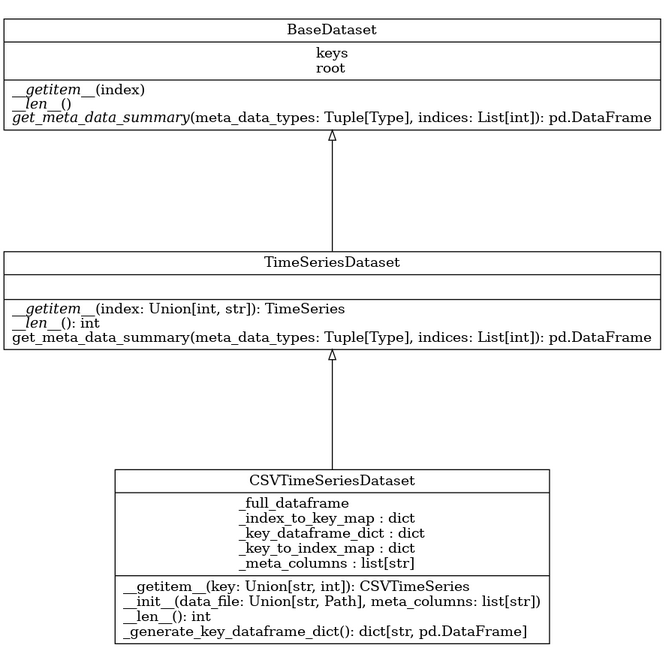
These classes are part of a system for handling time series datasets, particularly in the context of CSV files. 

### 1. BaseDataset (Abstract Base Class - ABC):
- **Purpose:** This class sets the basic rules for any dataset.
- **Methods:**
  - `__getitem__(self, index)`: Get an item from the dataset.
  - `__len__(self)`: Get the number of items in the dataset.
  - `get_meta_data_summary(self, meta_data_types, indices, **kwargs)`: Get a summary of metadata for specific items.
  - `keys(self)`: Get a list of unique identifiers for items in the dataset.
  - `root(self)`: Get the main directory of the dataset.

### 2. TimeSeriesDataset (Abstract Base Class - ABC, Subclass of BaseDataset):
- **Purpose:** This class builds on BaseDataset and is designed for handling time series datasets.
- **Methods:**
  - `__getitem__(self, index)`: Get an item from the time series dataset.
  - `__len__(self)`: Get the number of items in the time series dataset.
  - `get_meta_data_summary(self, meta_data_types, indices, **kwargs)`: Get metadata summary specific to time series datasets.

### 3. CSVTimeSeriesDataset (Subclass of TimeSeriesDataset):
- **Purpose:** This class is a specific version of TimeSeriesDataset for handling time series datasets stored in CSV files.
- **Methods:**
  - `__init__(self, data_file, meta_columns)`: Set up the CSV time series dataset. Read a CSV file, create mappings, and index-to-key relationships.
  - `_generate_key_dataframe_dict(self)`: Create mappings based on metadata columns.
  - `__getitem__(self, key)`: Get an item from the CSV time series dataset based on the key. It returns a `CSVTimeSeries` object.
  - `__len__(self)`: Get the number of items in the CSV time series dataset.

Overall, these classes provide a simple way to work with different datasets, especially those containing time series data in CSV format. The `CSVTimeSeriesDataset` is specifically useful for handling and managing time series data from CSV files.

<hr>

## Support Classes
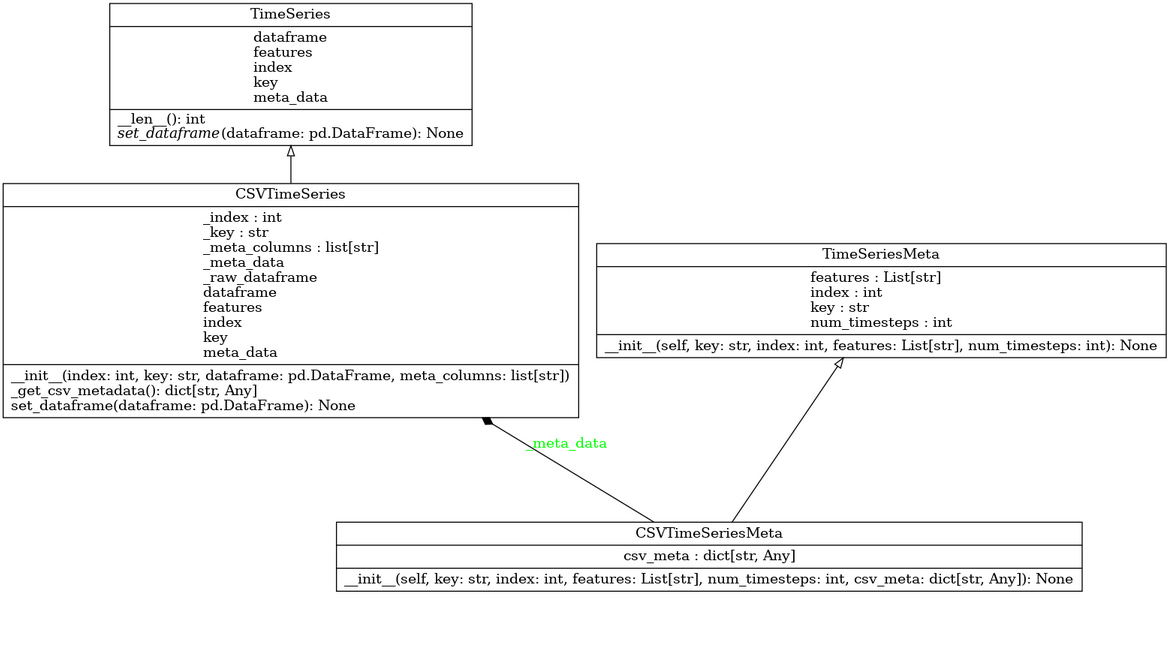

**1. TimeSeriesMeta:**
- **Purpose:** This data class stores metadata related to a generic time series.
- **Attributes:**
  - `key`: A unique identifier for the time series.
  - `index`: The index of the time series.
  - `features`: A list of feature names in the time series.
  - `num_timesteps`: The number of time steps in the time series.

**2. TimeSeries (Abstract Base Class - ABC):**
- **Purpose:** This abstract class outlines the structure and behavior expected from any time series class.
- **Properties and Methods:**
  - `index`: Abstract property to get the index of the time series.
  - `key`: Abstract property to get the key of the time series.
  - `dataframe`: Abstract property to get the dataframe of the time series.
  - `meta_data`: Abstract property to get the metadata of the time series.
  - `set_dataframe(self, dataframe: pd.DataFrame)`: Abstract method to set the dataframe of the time series.
  - `features`: Property to get the list of feature names of the time series.
  - `__len__(self)`: Get the length of the time series.

**3. CSVTimeSeriesMeta (Subclass of TimeSeriesMeta):**
- **Purpose:** This data class extends TimeSeriesMeta and specifically handles metadata for time series stored in CSV files.
- **Attributes:**
  - `csv_meta`: A dictionary containing metadata from the CSV file (e.g., subject, activity).

**4. CSVTimeSeries (Subclass of TimeSeries):**
- **Purpose:** This class is a concrete implementation of TimeSeries designed for handling time series data stored in CSV files.
- **Properties and Methods:**
  - `__init__(self, index, key, dataframe, meta_columns)`: Constructor for CSV time series.
  - `_get_csv_metadata(self)`: Private method to get one row of the metadata columns as a dictionary.
  - `index, key, features, dataframe, set_dataframe(self, dataframe), meta_data`: Implementations of properties/methods defined in TimeSeries.

**Relations:**

- **TimeSeries Blueprint:**
  - `TimeSeries` serves as a blueprint for any time series class, setting the standard for properties and methods that must be implemented by its subclasses.

- **CSVTimeSeries Implementation:**
  - `CSVTimeSeries` is a specific implementation of the `TimeSeries` blueprint. It is tailored for handling time series data stored in CSV files, providing concrete implementations for the abstract properties and methods defined in `TimeSeries`.

- **CSVTimeSeriesMeta Extension:**
  - `CSVTimeSeriesMeta` is an extension of `TimeSeriesMeta`. It builds upon the generic time series metadata structure but adds specific attributes that are relevant to CSV time series data. This extension allows it to handle additional metadata, such as details obtained from CSV files, while maintaining the core structure defined by `TimeSeriesMeta`.

**Metadata refers to additional information that describes or provides context about the time series data. This information helps in understanding and interpreting the data. E.g. subject, activity ~ labels*

***The key is a unique label or identifier, often meaningful and specific to the data point it represents.*

****The index is a numerical identifier based on the item's position in the dataset, starting from a certain value (e.g., zero or one) and increasing incrementally.*

***This was general documentation. We will explore most of the fields and methods on our specific HAR example.***

<hr>

# Implementation

In [6]:
from typing import Any

@dataclass
class CSVTimeSeriesMeta(TimeSeriesMeta):
    """
    Data class for metadata associated with time series data from CSV files.

    Attributes:
        csv_meta (dict[str, Any]): A dictionary containing metadata from the CSV file.
                                   This metadata may include information such as subject and activity.
    """
    csv_meta: dict[str, Any]

In [7]:
class CSVTimeSeries(TimeSeries):
    """
    Specific implementation of the TimeSeries class designed for handling time series data stored in CSV files.

    Attributes:
        _raw_dataframe (pd.DataFrame): The raw dataframe containing time series data, including metadata columns.
        _index (int): The index of the CSV time series.
        _key (str): The key or unique identifier of the CSV time series.
        _meta_columns (list[str]): List of columns considered as metadata in the CSV file.
        _meta_data (CSVTimeSeriesMeta): Metadata associated with the CSV time series.
   """
    def __init__(self, index: int, key: str, dataframe: pd.DataFrame, meta_columns: list[str] = []):
        """
        Constructor for CSV time series. Initializes the CSVTimeSeries object with provided data.

        Args:
            index (int): The index of the CSV time series.
            key (str): The key or unique identifier of the CSV time series.
            dataframe (pd.DataFrame): The raw dataframe containing time series data, including metadata columns.
            meta_columns (list[str]): List of columns considered as metadata in the CSV file.
        """
        self._raw_dataframe = dataframe
        self._index = index
        self._key = key
        self._meta_columns = meta_columns
        csv_meta = self._get_csv_metadata()
        self._meta_data = CSVTimeSeriesMeta(key=key, index=index, csv_meta=csv_meta, 
                                            features=self.features,
                                            num_timesteps=len(self))

    def _get_csv_metadata(self) -> dict[str, Any]:
        """
        Return first row of the metadata columns as a dictionary.
        """
        return self._raw_dataframe[self._meta_columns].iloc[0].to_dict()

    @property
    def index(self) -> int:
        """
        Get the index of the CSV time series.
        """
        return self._index

    @property
    def key(self) -> str:
        """
        Get the key of the CSV time series.
        """
        return self._key

    @property
    def features(self) -> list[str]:
        """
        Get the list of feature names in the CSV time series.
        """
        return self.dataframe.columns.to_list() #list(set(self.dataframe.columns.tolist()) - set(self._meta_columns))
    
    @property
    def dataframe(self) -> pd.DataFrame:
        """
        Get the dataframe of the CSV time series, excluding metadata columns.
        """
        return self._raw_dataframe[self._raw_dataframe.columns.difference(self._meta_columns)]

    def set_dataframe(self, dataframe: pd.DataFrame) -> None:
        """
        Set the dataframe of the CSV time series.
        """
        self._raw_dataframe = dataframe

    @property
    def meta_data(self) -> CSVTimeSeriesMeta:
        """
        Get the metadata associated with the CSV time series.
        """
        return self._meta_data

In [13]:
from typing import Union
import opendatasets as od
import pandas
import os 

def set2str(s: tuple) -> str:
    """
    Convert a tuple to a string by joining its elements with underscores.
    """
    s_str = [str(i) for i in s]
    return '_'.join(s_str)

class CSVTimeSeriesDataset(TimeSeriesDataset):
    """
    Specific implementation of TimeSeriesDataset for handling CSV time series datasets.

    Attributes:
        _meta_columns (list[str]): Columns that contain metadata (e.g., subject, activity) in the CSV file.
        _full_dataframe (pd.DataFrame): The full raw dataframe read from the CSV file.
        _key_dataframe_dict (dict[str, pd.DataFrame]): Dictionary mapping keys to corresponding dataframes.
        _index_to_key_map (dict[int, str]): Dictionary mapping indices to keys.
        _key_to_index_map (dict[str, int]): Dictionary mapping keys to indices.
    """
    def __init__(self, data_file: Union[str, Path], meta_columns: list[str] = []):
        """
        Constructor for CSV time series dataset. Reads the CSV file and initializes data structures.

        Args:
            data_file (Union[str, Path]): Path to the CSV file.
            meta_columns (List[str]): Columns that contain metadata in the CSV file.
        """

        # download data automatically
        out_dir = '../../datafiles'
        # Download the file if it does not exist already
        if not os.path.exists(data_file):
            od.download('https://www.kaggle.com/datasets/parsabg/stocknewseventssentiment-snes-10/download?datasetVersionNumber=1', data_dir = out_dir)
        self._meta_columns = meta_columns # columns that contain metadata (e.g. subject, activity)
        self._full_dataframe = pd.read_csv(data_file)

        self._key_dataframe_dict = self._generate_key_dataframe_dict()
        # generate index to key and key to index maps
        self._index_to_key_map = {}
        self._key_to_index_map = {}
        for i, key in enumerate(self._key_dataframe_dict.keys()):
            self._index_to_key_map[i] = key
            self._key_to_index_map[key] = i


    def _generate_key_dataframe_dict(self) -> dict[str, pd.DataFrame]:
        """
        Generate a dictionary mapping keys to dataframes based on metadata columns.

        Returns:
            dict[str, pd.DataFrame]: Dictionary mapping keys to corresponding dataframes.
        """
        key_dataframe_dict = {}
        for metadata_set, df in self._full_dataframe.groupby(self._meta_columns):
            key = set2str(metadata_set)
            # for more complicated metadata, you might want to use a more sophisticated key
            # and call it something like self._get_key(df, self._meta_columns)
            key_dataframe_dict[key] = df
        return key_dataframe_dict
        

    def __getitem__(self, key: Union[str, int]) -> CSVTimeSeries:
        """
        Get an item from the CSV time series dataset based on the key. Returns a CSVTimeSeries object.

        Args:
            key (Union[str, int]): Key or index to retrieve the CSVTimeSeries object.

        Returns:
            CSVTimeSeries: The CSVTimeSeries object.
        """
        assert isinstance(key, (str, int)), f"Key must be either a string or an integer, got {type(key)}"
        if isinstance(key, int):
            idx = key
            key = self._index_to_key_map[idx]
        else:
            idx = self._key_to_index_map[key]
             
        ts_dataframe = self._key_dataframe_dict[key]

        return CSVTimeSeries(index=idx, key=key, dataframe=ts_dataframe, meta_columns=self._meta_columns)
    
    def __len__(self) -> int:
        """
        Get the length of the CSV time series dataset.
        """
        return len(self._key_dataframe_dict)

# Automated loading

For the sake of simplicity we are demontrating you how to wrtite custom dataset using already downloader from the web `.csv` file.
However it would be your task to implement automatic downloading. It could be the part of our `CSVTimeSeriesDataset` init method. 
For example, to receive the data directory, to check if files are downloaded and preprocessed, if not then download and preprocess.

# Explore on SNES dataset

Having our .csv file we create our `CSVTimeSeriesDataset`

In [14]:
dataset = CSVTimeSeriesDataset(data_file=TRAIN_FILE, meta_columns=['Symbol','Security'])

Let's explore main fields we have in our dataset:

In [15]:
exclude_for_now = ['_key_dataframe_dict', '_index_to_key_map', '_key_to_index_map']
for key, value in vars(dataset).items():
    if key in exclude_for_now: continue
    print("="*100)    
    print(key)
    display(value)

_meta_columns


['Symbol', 'Security']

_full_dataframe


,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Security,GICS Sector,...,News - Analyst Comments,News - Stocks,News - Dividends,News - Corporate Earnings,News - Mergers & Acquisitions,News - Store Openings,News - Product Recalls,News - Adverse Events,News - Personnel Changes,News - Stock Rumors
0,2020-09-30,160.929993,163.100006,158.610001,160.179993,150.921692,3056900.0,MMM,3M,Industrials,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-01,160.669998,161.899994,157.720001,158.789993,149.612045,1989100.0,MMM,3M,Industrials,...,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-10-02,156.470001,161.940002,156.250000,160.360001,151.091309,1768600.0,MMM,3M,Industrials,...,2.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2020-10-05,162.250000,163.500000,161.759995,162.750000,153.343170,1457000.0,MMM,3M,Industrials,...,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
4,2020-10-06,163.440002,165.699997,161.830002,162.229996,152.853195,2021900.0,MMM,3M,Industrials,...,3.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217806,2022-06-24,172.000000,174.679993,171.389999,174.610001,174.610001,3255000.0,ZTS,Zoetis,Health Care,...,7.0,7.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0
217807,2022-06-27,173.839996,175.210007,172.929993,173.600006,173.600006,1378400.0,ZTS,Zoetis,Health Care,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217808,2022-06-28,172.960007,174.669998,170.009995,170.119995,170.119995,1725800.0,ZTS,Zoetis,Health Care,...,7.0,7.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
217809,2022-06-29,172.000000,175.149994,170.149994,173.919998,173.919998,1658000.0,ZTS,Zoetis,Health Care,...,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Having our matadata columns (i.e. columns by which we will split the data) and the full dataframe we now can generate `_key_dataframe_dict`.


In the function `_generate_key_dataframe_dict` we call `self._full_dataframe.groupby(self._meta_columns)`.
For visibility, we are adding `count` call in statement below to demonstrate intermediate result of this operation.

In [16]:
dataset._full_dataframe.groupby(dataset._meta_columns).count()

,,Date,Open,High,Low,Close,Adj Close,Volume,GICS Sector,GICS Sub-Industry,News - All News Volume,...,News - Analyst Comments,News - Stocks,News - Dividends,News - Corporate Earnings,News - Mergers & Acquisitions,News - Store Openings,News - Product Recalls,News - Adverse Events,News - Personnel Changes,News - Stock Rumors
Symbol,Security,,,,,,,,,,,,,,,,,,,,,
A,Agilent Technologies,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
AAL,American Airlines Group,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
AAP,Advance Auto Parts,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
AAPL,Apple Inc.,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
ABBV,AbbVie,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,Yum! Brands,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
ZBH,Zimmer Biomet,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440
ZBRA,Zebra Technologies,441,441,441,441,441,441,441,441,441,440,...,440,440,440,440,440,440,440,440,440,440


The loop through  `self._full_dataframe.groupby(self._meta_columns)` gives us 2 idicies and the filtered dataframe. 

In [17]:
for metadata_set, df in dataset._full_dataframe.groupby(dataset._meta_columns):
    print(metadata_set)
    display(df.head(3))
    break

('A', 'Agilent Technologies')


,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Security,GICS Sector,...,News - Analyst Comments,News - Stocks,News - Dividends,News - Corporate Earnings,News - Mergers & Acquisitions,News - Store Openings,News - Product Recalls,News - Adverse Events,News - Personnel Changes,News - Stock Rumors
5733,2020-09-30,100.540001,101.889999,100.309998,100.940002,99.718689,1362200.0,A,Agilent Technologies,Health Care,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5734,2020-10-01,101.769997,102.410004,100.540001,101.220001,99.995293,723600.0,A,Agilent Technologies,Health Care,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5735,2020-10-02,100.209999,101.279999,99.809998,100.010002,98.799950,712200.0,A,Agilent Technologies,Health Care,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From `metadata_set` we form the unique key by concatenating all elements with underscore. The format is *subject_activity*, e.g. *1_LAYING*
Then store everything in a dictionary where keys are those unique concatenations and values are filtered dataframes.

In [18]:
for k, v in dataset._key_dataframe_dict.items():
    print("="*100)
    print(k)
    print(f'assigned dataframe of {v.shape[0]} timesteps and {v.shape[1]} columns, {v.shape[1]-2} features')
    print()

A_Agilent Technologies
assigned dataframe of 441 timesteps and 27 columns, 25 features

AAL_American Airlines Group
assigned dataframe of 441 timesteps and 27 columns, 25 features

AAP_Advance Auto Parts
assigned dataframe of 441 timesteps and 27 columns, 25 features

AAPL_Apple Inc.
assigned dataframe of 441 timesteps and 27 columns, 25 features

ABBV_AbbVie
assigned dataframe of 441 timesteps and 27 columns, 25 features

ABC_AmerisourceBergen
assigned dataframe of 441 timesteps and 27 columns, 25 features

ABMD_Abiomed
assigned dataframe of 441 timesteps and 27 columns, 25 features

ABT_Abbott
assigned dataframe of 441 timesteps and 27 columns, 25 features

ACN_Accenture
assigned dataframe of 441 timesteps and 27 columns, 25 features

ADBE_Adobe Inc.
assigned dataframe of 441 timesteps and 27 columns, 25 features

ADI_Analog Devices
assigned dataframe of 441 timesteps and 27 columns, 25 features

ADM_ADM
assigned dataframe of 441 timesteps and 27 columns, 25 features

ADP_ADP
assigne

We finally create `self._index_to_key_map` and `self._key_to_index_map` to enable `__getitem__()` methods. We print a couple of those dictionaries side by side below.

In [19]:
for idx, el1, el2 in zip(range(len(dataset._index_to_key_map.keys())), 
                         dataset._index_to_key_map.items(),
                         dataset._key_to_index_map.items()):
    if idx==3: break
    print(f"{idx}\t\t {el1}\t\t{el2}")

0		 (0, 'A_Agilent Technologies')		('A_Agilent Technologies', 0)
1		 (1, 'AAL_American Airlines Group')		('AAL_American Airlines Group', 1)
2		 (2, 'AAP_Advance Auto Parts')		('AAP_Advance Auto Parts', 2)


The `__getitem__()` method will return us an instance of `CSVTimeSeries` created on fly.

In [20]:
timeseries = dataset.__getitem__(0)
timeseries

We now explore most of the `CSVTimeSeries` fields.

In [21]:
exclude_for_now = ['_meta_data']
for key, value in vars(timeseries).items():
    if key in exclude_for_now: continue
    print("="*100)    
    print(key)
    display(value)

_raw_dataframe


,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Security,GICS Sector,...,News - Analyst Comments,News - Stocks,News - Dividends,News - Corporate Earnings,News - Mergers & Acquisitions,News - Store Openings,News - Product Recalls,News - Adverse Events,News - Personnel Changes,News - Stock Rumors
5733,2020-09-30,100.540001,101.889999,100.309998,100.940002,99.718689,1362200.0,A,Agilent Technologies,Health Care,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5734,2020-10-01,101.769997,102.410004,100.540001,101.220001,99.995293,723600.0,A,Agilent Technologies,Health Care,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5735,2020-10-02,100.209999,101.279999,99.809998,100.010002,98.799950,712200.0,A,Agilent Technologies,Health Care,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5736,2020-10-05,100.989998,103.459999,100.959999,103.120003,102.056000,803900.0,A,Agilent Technologies,Health Care,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5737,2020-10-06,103.120003,103.330002,101.480003,101.629997,100.581367,1078000.0,A,Agilent Technologies,Health Care,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6169,2022-06-24,119.949997,121.349998,118.449997,121.290001,121.075546,3780400.0,A,Agilent Technologies,Health Care,...,7.0,7.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
6170,2022-06-27,121.830002,122.300003,119.849998,120.570000,120.356819,1805700.0,A,Agilent Technologies,Health Care,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6171,2022-06-28,120.449997,121.239998,116.720001,117.059998,116.853020,1426100.0,A,Agilent Technologies,Health Care,...,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6172,2022-06-29,117.190002,118.540001,116.239998,117.900002,117.691544,906600.0,A,Agilent Technologies,Health Care,...,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_index


0

_key


'A_Agilent Technologies'

_meta_columns


['Symbol', 'Security']

The field `_meta_data` is an instance of `CSVTimeSeriesMeta`, which contains a description of our timeseries. 

In [22]:
timeseriesmeta = timeseries._meta_data

In [23]:
exclude_for_now = []
for key, value in vars(timeseriesmeta).items():
    if key in exclude_for_now: continue
    print("="*100)    
    print(key)
    display(value)

key


'A_Agilent Technologies'

index


0

features


['Adj Close',
 'Close',
 'Date',
 'GICS Sector',
 'GICS Sub-Industry',
 'High',
 'Low',
 'News - Adverse Events',
 'News - All News Volume',
 'News - Analyst Comments',
 'News - Corporate Earnings',
 'News - Dividends',
 'News - Layoffs',
 'News - Mergers & Acquisitions',
 'News - Negative Sentiment',
 'News - New Products',
 'News - Personnel Changes',
 'News - Positive Sentiment',
 'News - Product Recalls',
 'News - Stock Rumors',
 'News - Stocks',
 'News - Store Openings',
 'News - Volume',
 'Open',
 'Volume']

num_timesteps


441

csv_meta


{'Symbol': 'A', 'Security': 'Agilent Technologies'}

# After developing

When you are sure that your dataset is implemented correctly, you shoul come up with the name for it and register it within the code base.

Go to `~/tsbench/tslib/loading/__init__.py` and add your dataset.
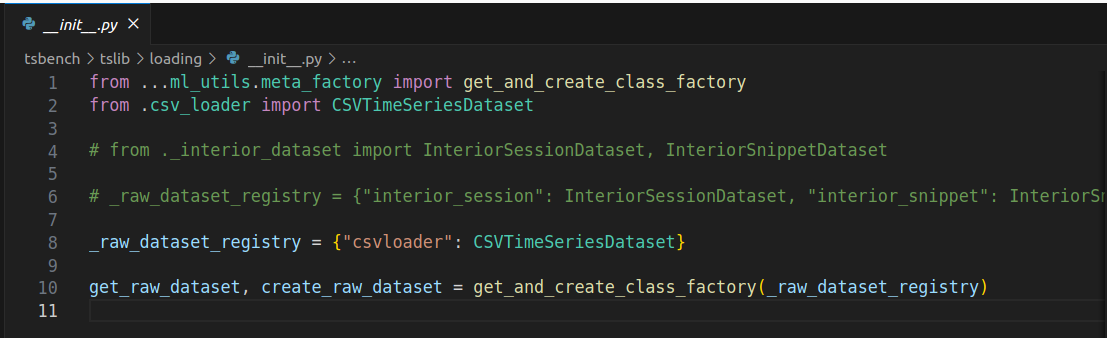